## Gesture Recognition - Case Study - Visalakshi G & Alok Tripathi

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested in the problem specification, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

#### Import required Libraries

In [1]:
import numpy as np
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
from scipy.misc import imread,imresize

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Using TensorFlow backend.


In [3]:
import cv2,sys
import matplotlib.pyplot as plt
%matplotlib inline
#Keras libraries 
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout


In [4]:
project_folder='.'
print('Project folder on local machine :',project_folder)

Project folder on local machine : .


In [5]:
!nvidia-smi

Sun Apr 18 09:53:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.09       Driver Version: 461.09       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     4W /  N/A |    132MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Custom function used to plot the metrics

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Generator code

In [7]:
class ModelClass(metaclass= abc.ABCMeta):    
    def initialize_path(self,project_folder,num):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        self.model_num=num
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 
            remaining_seq=len(t)%batch_size        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    #function for image data processing in one batch
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):    
        seq_len = remaining_seq if remaining_seq else batch_size    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))         

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                #Data Augmentation with Affine transformation
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)                     
                    cropped=shifted[x0:x1,y0:y1,:]                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        return(batch_data,batch_labels)
    
    #Function to perform training of the model
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model' + '_'+str(self.model_num)+'_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

#### Experimenting with Sample Models 

In [8]:
class ModelConv3D1(ModelClass):    
    def define_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_width,self.image_height,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder,0)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)   

#### Test Image Reduction and view the result

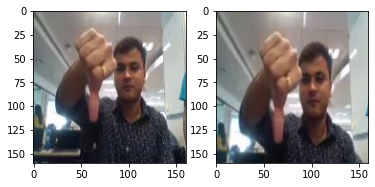

In [10]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder,0)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)
g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

### Experimenting with image size, batch size, samples to use & number of epochs

In [11]:
#Sample image with batch size = 40, frames to sample = 30
#conv_3d1.train_model(conv_3d1_model)

**Result**<BR>
Limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...Got the below error
ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [12]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


#### Reduced batchsize, fames in sample for image resolution 160x160 image

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder,0)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=3)
conv_3d1_model1=conv_3d1.define_model()
print("Total Params:", conv_3d1_model1.count_params())
conv_3d1.train_model(conv_3d1_model1)

Total Params: 1736389
Epoch 1/3
 53/133 [==========>...................] - ETA: 1:14 - loss: 1.8929 - categorical_accuracy: 0.3358

In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder,0)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=3)
conv_3d1_model1=conv_3d1.define_model()
print("Total Params:", conv_3d1_model1.count_params())
conv_3d1.train_model(conv_3d1_model1)

Total Params: 1736389
Epoch 1/3
67/67 [==============================] - 173s 3s/step - loss: 1.6250 - categorical_accuracy: 0.4042 - val_loss: 2.8705 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_0_2021-04-1621_34_43.120127/model-00001-1.63680-0.40422-2.87048-0.16000.h5
Epoch 2/3
67/67 [==============================] - 166s 2s/step - loss: 0.9568 - categorical_accuracy: 0.6335 - val_loss: 5.4806 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_0_2021-04-1621_34_43.120127/model-00002-0.95926-0.63348-5.48055-0.16000.h5
Epoch 3/3
67/67 [==============================] - 161s 2s/step - loss: 0.8118 - categorical_accuracy: 0.7149 - val_loss: 4.7243 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_0_2021-04-1621_34_43.120127/model-00003-0.79383-0.71493-4.72428-0.22000.h5


#### Reduced Image resolution, batch size

In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder,0)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=3)
conv_3d1_model1=conv_3d1.define_model()
print("Total Params:", conv_3d1_model1.count_params())
conv_3d1.train_model(conv_3d1_model1)

Total Params: 900805
Epoch 1/3
67/67 [==============================] - 296s 4s/step - loss: 1.5245 - categorical_accuracy: 0.4178 - val_loss: 5.9442 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_0_2021-04-1621_43_12.397096/model-00001-1.52842-0.41780-5.94420-0.21000.h5
Epoch 2/3
67/67 [==============================] - 290s 4s/step - loss: 1.0552 - categorical_accuracy: 0.5913 - val_loss: 8.1338 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_0_2021-04-1621_43_12.397096/model-00002-1.04275-0.59125-8.13380-0.21000.h5
Epoch 3/3
67/67 [==============================] - 294s 4s/step - loss: 0.8805 - categorical_accuracy: 0.6757 - val_loss: 5.6853 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_0_2021-04-1621_43_12.397096/model-00003-0.86719-0.67572-5.68534-0.21000.h5


In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder,0)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=3)
conv_3d1_model1=conv_3d1.define_model()
print("Total Params:", conv_3d1_model1.count_params())
conv_3d1.train_model(conv_3d1_model1)

Total Params: 900805
Epoch 1/3
67/67 [==============================] - 158s 2s/step - loss: 1.5334 - categorical_accuracy: 0.4314 - val_loss: 3.1007 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_0_2021-04-1621_58_01.847484/model-00001-1.53373-0.43137-3.10065-0.21000.h5
Epoch 2/3
67/67 [==============================] - 153s 2s/step - loss: 1.0691 - categorical_accuracy: 0.5928 - val_loss: 2.7278 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_0_2021-04-1621_58_01.847484/model-00002-1.06801-0.59276-2.72783-0.22000.h5
Epoch 3/3
67/67 [==============================] - 155s 2s/step - loss: 0.8411 - categorical_accuracy: 0.6757 - val_loss: 5.5715 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_0_2021-04-1621_58_01.847484/model-00003-0.83970-0.67572-5.57153-0.16000.h5


#### Reduced Image resolution 100x100, batch size

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder,0)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
67/67 [==============================] - 292s 4s/step - loss: 1.6106 - categorical_accuracy: 0.3997 - val_loss: 2.4490 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_0_2021-04-1622_05_59.401193/model-00001-1.61515-0.39970-2.44902-0.23000.h5
Epoch 2/3
67/67 [==============================] - 264s 4s/step - loss: 1.1984 - categorical_accuracy: 0.5520 - val_loss: 4.9943 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_0_2021-04-1622_05_59.401193/model-00002-1.19736-0.55204-4.99433-0.22000.h5
Epoch 3/3
67/67 [==============================] - 108s 2s/step - loss: 1.0116 - categorical_accuracy: 0.6124 - val_loss: 6.7848 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_0_2021-04-1622_05_59.401193/model-00003-1.01375-0.61237-6.78479-0.16000.h5


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder,0)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
67/67 [==============================] - 67s 1s/step - loss: 1.6251 - categorical_accuracy: 0.4148 - val_loss: 4.2821 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_0_2021-04-1622_17_13.024222/model-00001-1.62326-0.41478-4.28210-0.16000.h5
Epoch 2/3
67/67 [==============================] - 67s 994ms/step - loss: 1.0587 - categorical_accuracy: 0.6124 - val_loss: 5.6651 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_0_2021-04-1622_17_13.024222/model-00002-1.05223-0.61237-5.66506-0.16000.h5
Epoch 3/3
67/67 [==============================] - 68s 1s/step - loss: 0.8422 - categorical_accuracy: 0.6953 - val_loss: 6.1335 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_0_2021-04-1622_17_13.024222/model-00003-0.84654-0.69532-6.13346-0.16000.h5


**Inference**
1. Image resolution, number of frames in sequence influence execution time.
2. Batch size has very little influence on execution time compared to other parameters.
3. Models are created by keeping the batch size fixed around(3-10) and varying other parameters like image resolution, number of samples in sequence to create better training models.

### Model 1  - Base model with no data augmentation

In [19]:
class ModelConv3D(ModelClass):    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv3d1=ModelConv3D()
conv3d1.initialize_path(project_folder,1)
conv3d1.initialize_image_properties(image_height=160,image_width=160)
conv3d1.initialize_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=15)
conv3d1_model=conv3d1.define_model()
conv3d1_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_30 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 10, 80, 80, 32)   

Total Params: 1117061
Epoch 1/15
67/67 [==============================] - 98s 1s/step - loss: 1.7432 - categorical_accuracy: 0.3771 - val_loss: 2.3039 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_1_2021-04-1622_20_39.954718/model-00001-1.72252-0.37707-2.30386-0.21000.h5
Epoch 2/15
67/67 [==============================] - 95s 1s/step - loss: 1.1567 - categorical_accuracy: 0.5445 - val_loss: 6.9458 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_1_2021-04-1622_20_39.954718/model-00002-1.15562-0.54449-6.94581-0.21000.h5
Epoch 3/15
67/67 [==============================] - 92s 1s/step - loss: 0.7689 - categorical_accuracy: 0.6772 - val_loss: 4.4636 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_1_2021-04-1622_20_39.954718/model-00003-0.77449-0.67722-4.46362-0.21000.h5
Epoch 4/15
67/67 [==============================] - 92s 1s/step - loss: 0.7230 - categorical_accuracy: 0.7421 - val_loss: 2.8052 - val_categorical_accura

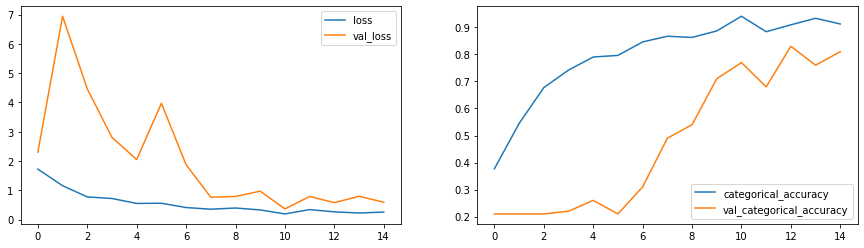

In [21]:
print("Total Params:", conv3d1_model.count_params())
history_model1 = conv3d1.train_model(conv3d1_model)
plot(history_model1)

**Inferences**
1. Model is overfitting.
2. Best training accuracy is 0.93 and validation accuracy is around 0.76.
3. Try data augmentation to reduce overfitting and improve model performance.

### Model 2 - Base model + Data Augmentation

In [22]:
conv3d2=ModelConv3D()
conv3d2.initialize_path(project_folder,2)
conv3d2.initialize_image_properties(image_height=160,image_width=160)
conv3d2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=25)
conv3d2_model=conv3d2.define_model(dense_neurons=256,dropout=0.5)
conv3d2_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_34 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 8, 80, 80, 32)    

Total Params: 3638981
Epoch 1/25
133/133 [==============================] - 161s 1s/step - loss: 2.1802 - categorical_accuracy: 0.3062 - val_loss: 2.2524 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_2_2021-04-1622_43_57.077354/model-00001-2.18103-0.30618-2.25243-0.22000.h5
Epoch 2/25
133/133 [==============================] - 152s 1s/step - loss: 1.8658 - categorical_accuracy: 0.3499 - val_loss: 4.6174 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_2_2021-04-1622_43_57.077354/model-00002-1.86811-0.34992-4.61743-0.16000.h5
Epoch 3/25
133/133 [==============================] - 153s 1s/step - loss: 1.6499 - categorical_accuracy: 0.3763 - val_loss: 2.0903 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_2_2021-04-1622_43_57.077354/model-00003-1.65132-0.37632-2.09026-0.44000.h5
Epoch 4/25
133/133 [==============================] - 154s 1s/step - loss: 1.5952 - categorical_accuracy: 0.3906 - val_loss: 4.3431 - val_catego

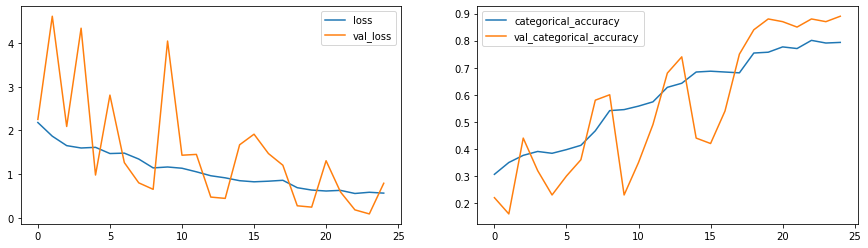

In [23]:
print("Total Params:", conv3d2_model.count_params())
history_model2=conv3d2.train_model(conv3d2_model,augment_data=True)
plot(history_model2)

**Inference**
1. Overfitting problem is slighlty reduced. 
2. Best training accuracy is about 0.80 and validation accuracy is 0.88
3. Values of accuracy/loss are not consistent over epochs.

**Enhance the model further for stable and better result.Let us reduce image size and see.**

### Model 3 - Base model+Data Augmentation+Image Resolution, Filter size reduced

In [24]:
class ModelConv3D1(ModelClass):    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv3d3=ModelConv3D1()
conv3d3.initialize_path(project_folder,3)
conv3d3.initialize_image_properties(image_height=120,image_width=120)
conv3d3.initialize_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=30)
conv3d3_model=conv3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3d3_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 30, 120, 120, 16)  400       
_________________________________________________________________
activation_37 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_38 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 15, 60, 60, 32)  

Total Params: 1762613
Epoch 1/30
133/133 [==============================] - 268s 2s/step - loss: 2.1579 - categorical_accuracy: 0.3183 - val_loss: 4.0769 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_3_2021-04-1623_48_09.082315/model-00001-2.15587-0.31825-4.07694-0.23000.h5
Epoch 2/30
133/133 [==============================] - 255s 2s/step - loss: 1.7686 - categorical_accuracy: 0.3959 - val_loss: 4.9252 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_3_2021-04-1623_48_09.082315/model-00002-1.76732-0.39593-4.92522-0.21000.h5
Epoch 3/30
133/133 [==============================] - 253s 2s/step - loss: 1.5151 - categorical_accuracy: 0.4887 - val_loss: 2.7953 - val_categorical_accuracy: 0.1900

Epoch 00003: saving model to model_3_2021-04-1623_48_09.082315/model-00003-1.51323-0.48869-2.79526-0.19000.h5
Epoch 4/30
133/133 [==============================] - 253s 2s/step - loss: 1.4879 - categorical_accuracy: 0.5136 - val_loss: 1.3633 - val_catego

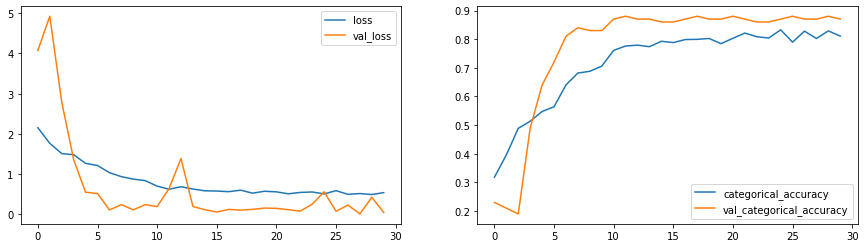

In [26]:
print("Total Params:", conv3d3_model.count_params())
history_model3=conv3d3.train_model(conv3d3_model,augment_data=True)
plot(history_model3)

**Inferences**
1. Reduction of image resolution and filter size helped to reduce overfitting further.
2. Best training accuracy is 0.83 and validation accuracy is 0.87.Decent performance with reduced image resolution.
3. Add additional layers and see if it causes further improvement.

### Model 4 -  Base model + Data Augmentation + additional layers

In [27]:
class ModelConv3D2(ModelClass):    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))     

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv3d4=ModelConv3D2()
conv3d4.initialize_path(project_folder,4)
conv3d4.initialize_image_properties(image_height=120,image_width=120)
conv3d4.initialize_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=30)
conv3d4_model=conv3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv3d4_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_42 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 10, 60, 60, 16)  

Total Params: 2556533
Epoch 1/30
133/133 [==============================] - 196s 1s/step - loss: 2.3366 - categorical_accuracy: 0.2790 - val_loss: 5.2545 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_4_2021-04-1701_55_37.775743/model-00001-2.33458-0.27903-5.25449-0.26000.h5
Epoch 2/30
133/133 [==============================] - 181s 1s/step - loss: 1.9596 - categorical_accuracy: 0.3333 - val_loss: 2.0609 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_4_2021-04-1701_55_37.775743/model-00002-1.96224-0.33333-2.06094-0.30000.h5
Epoch 3/30
133/133 [==============================] - 189s 1s/step - loss: 1.8209 - categorical_accuracy: 0.3311 - val_loss: 1.3260 - val_categorical_accuracy: 0.3700

Epoch 00003: saving model to model_4_2021-04-1701_55_37.775743/model-00003-1.82071-0.33107-1.32601-0.37000.h5
Epoch 4/30
133/133 [==============================] - 185s 1s/step - loss: 1.6540 - categorical_accuracy: 0.3891 - val_loss: 1.6819 - val_catego

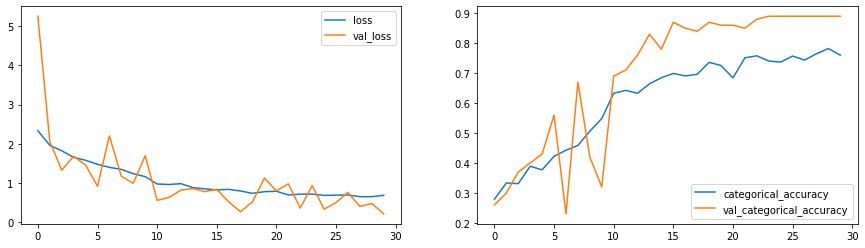

In [29]:
print("Total Params:", conv3d4_model.count_params())
history_model4=conv3d4.train_model(conv3d4_model,augment_data=True)
plot(history_model4)

**Inferences**
1. Model is underfitting now. 
2. Best training accuracy is about 0.78 and validation accuracy is 0.89.
3. Reduce Image resolution with data augmentation.

### Model 5 - Base model+Data Augmentation+Image resolution,filter,dense neurons reduced

In [30]:
class ModelConv3D3(ModelClass):    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv3d5=ModelConv3D3()
conv3d5.initialize_path(project_folder,5)
conv3d5.initialize_image_properties(image_height=120,image_width=120)
conv3d5.initialize_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=25)
conv3d5_model=conv3d5.define_model(filtersize=(2,2,2),dense_neurons=64,dropout=0.25)
conv3d5_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_49 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_50 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 10, 60, 60, 32)  

Total Params: 504709
Epoch 1/25
133/133 [==============================] - 177s 1s/step - loss: 1.9922 - categorical_accuracy: 0.3145 - val_loss: 5.1814 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_5_2021-04-1703_29_13.387548/model-00001-1.99245-0.31448-5.18139-0.21000.h5
Epoch 2/25
133/133 [==============================] - 168s 1s/step - loss: 1.3794 - categorical_accuracy: 0.4811 - val_loss: 4.7366 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_5_2021-04-1703_29_13.387548/model-00002-1.38179-0.48115-4.73661-0.26000.h5
Epoch 3/25
133/133 [==============================] - 170s 1s/step - loss: 1.1997 - categorical_accuracy: 0.5603 - val_loss: 3.8697 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_5_2021-04-1703_29_13.387548/model-00003-1.19747-0.56033-3.86971-0.24000.h5
Epoch 4/25
133/133 [==============================] - 171s 1s/step - loss: 1.0455 - categorical_accuracy: 0.6161 - val_loss: 1.1685 - val_categor

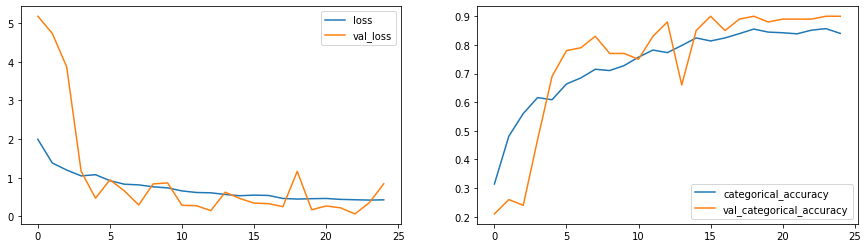

In [32]:
print("Total Params:", conv3d5_model.count_params())
history_model5=conv3d5.train_model(conv3d5_model,augment_data=True)
plot(history_model5)

**Inferences**
1. Model performance improved compared to earlier low memory foot print models and gave decent result.
2. Best training accuracy is about 0.85 and validation accuracy is 0.90.
3. Try with additional data augmentation

In [53]:
class ModelClassAugmented(metaclass= abc.ABCMeta):    
    def initialize_path(self,project_folder,num):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        self.model_num=num
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                               
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model' +'_'+str(self.model_num)+ '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### Model 6 - CNN+Data Augmented(with additional rotations)

In [34]:
class ModelConv3D4(ModelClassAugmented):    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv3d6=ModelConv3D4()
conv3d6.initialize_path(project_folder,6)
conv3d6.initialize_image_properties(image_height=160,image_width=160)
conv3d6.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=30)
conv3d6_model=conv3d6.define_model(dense_neurons=256,dropout=0.5)
conv3d6_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_54 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 8, 80, 80, 32)   

Total Params: 3638981
Epoch 1/30
133/133 [==============================] - 166s 1s/step - loss: 2.1036 - categorical_accuracy: 0.3409 - val_loss: 6.1138 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_6_2021-04-1704_40_10.592098/model-00001-2.10275-0.34087-6.11382-0.16000.h5
Epoch 2/30
133/133 [==============================] - 159s 1s/step - loss: 1.7201 - categorical_accuracy: 0.4299 - val_loss: 6.6390 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_6_2021-04-1704_40_10.592098/model-00002-1.72081-0.42986-6.63899-0.23000.h5
Epoch 3/30
133/133 [==============================] - 160s 1s/step - loss: 1.4202 - categorical_accuracy: 0.5339 - val_loss: 6.1545 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_6_2021-04-1704_40_10.592098/model-00003-1.42037-0.53394-6.15450-0.24000.h5
Epoch 4/30
133/133 [==============================] - 161s 1s/step - loss: 1.2503 - categorical_accuracy: 0.5777 - val_loss: 2.9239 - val_catego

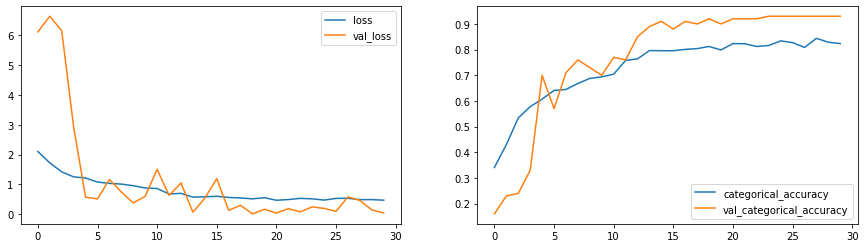

In [36]:
print("Total Params:", conv3d6_model.count_params())
history_model6=conv3d6.train_model(conv3d6_model,augment_data=True)
plot(history_model6)

**Inferences**
1. Model is underfitting in some epochs.
2. Best training accuracy is about 0.83 and validation accuracy is 0.94.
3. Add additional augmented data for base model and train with reduced image resolution, learning rate.

### Model 7 - Base Model + Additional Augmentation with reduced Image Resolution and learning rate

In [37]:
class ModelConv3D5(ModelClassAugmented):    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
conv3d7=ModelConv3D5()
conv3d7.initialize_path(project_folder,7)
conv3d7.initialize_image_properties(image_height=120,image_width=120)
conv3d7.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=30)
conv3d7_model=conv3d7.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3d7_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_57 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_58 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 8, 60, 60, 32)   

Total Params: 1762613
Epoch 1/30
133/133 [==============================] - 151s 1s/step - loss: 2.1135 - categorical_accuracy: 0.3311 - val_loss: 7.0635 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_7_2021-04-1706_00_50.630745/model-00001-2.11665-0.33107-7.06350-0.16000.h5
Epoch 2/30
133/133 [==============================] - 144s 1s/step - loss: 1.6536 - categorical_accuracy: 0.4630 - val_loss: 5.7554 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_7_2021-04-1706_00_50.630745/model-00002-1.65008-0.46305-5.75540-0.16000.h5
Epoch 3/30
133/133 [==============================] - 145s 1s/step - loss: 1.4542 - categorical_accuracy: 0.5121 - val_loss: 3.1096 - val_categorical_accuracy: 0.2800

Epoch 00003: saving model to model_7_2021-04-1706_00_50.630745/model-00003-1.45237-0.51207-3.10959-0.28000.h5
Epoch 4/30
133/133 [==============================] - 145s 1s/step - loss: 1.3088 - categorical_accuracy: 0.5468 - val_loss: 2.7063 - val_catego

133/133 [==============================] - 146s 1s/step - loss: 0.6321 - categorical_accuracy: 0.7873 - val_loss: 0.1445 - val_categorical_accuracy: 0.8700

Epoch 00029: saving model to model_7_2021-04-1706_00_50.630745/model-00029-0.63092-0.78733-0.14451-0.87000.h5
Epoch 30/30
133/133 [==============================] - 145s 1s/step - loss: 0.6299 - categorical_accuracy: 0.7715 - val_loss: 0.3462 - val_categorical_accuracy: 0.8800

Epoch 00030: saving model to model_7_2021-04-1706_00_50.630745/model-00030-0.62956-0.77149-0.34618-0.88000.h5


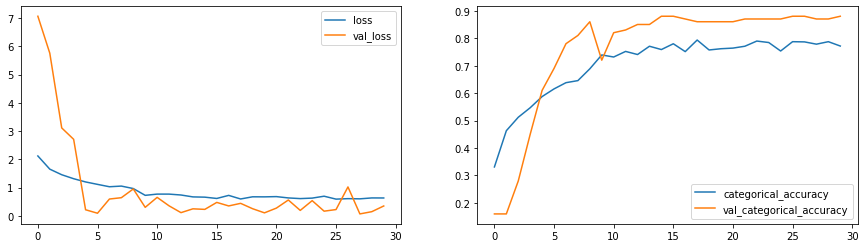

In [39]:
print("Total Params:", conv3d7_model.count_params())
history_model7=conv3d7.train_model(conv3d7_model,augment_data=True)
plot(history_model7)

**Inference**
1. Underfitting is reduced.
2. Best training accuracy seen is about 0.79 and training accuracy is 0.87.
3. Let us see if additional layers & dropouts further improve the performance.

### Model 8 - CNN+Data Augmentation+Additional Layers&Dropouts (Model 7 with additinal layers and dropouts)

In [40]:
class ModelConv3D6(ModelClassAugmented):    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
conv3d8=ModelConv3D6()
conv3d8.initialize_path(project_folder,8)
conv3d8.initialize_image_properties(image_height=120,image_width=120)
conv3d8.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=25)
conv3d8_model=conv3d8.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv3d8_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_61 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_62 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 8, 60, 60, 16)   

Total Params: 2556533
Epoch 1/25
133/133 [==============================] - 171s 1s/step - loss: 1.9578 - categorical_accuracy: 0.3431 - val_loss: 1.9436 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_8_2021-04-1707_14_01.447859/model-00001-1.95743-0.34314-1.94362-0.21000.h5
Epoch 2/25
133/133 [==============================] - 169s 1s/step - loss: 1.6674 - categorical_accuracy: 0.3891 - val_loss: 3.6283 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_8_2021-04-1707_14_01.447859/model-00002-1.66771-0.38914-3.62831-0.21000.h5
Epoch 3/25
133/133 [==============================] - 171s 1s/step - loss: 1.4324 - categorical_accuracy: 0.4834 - val_loss: 3.5240 - val_categorical_accuracy: 0.1900

Epoch 00003: saving model to model_8_2021-04-1707_14_01.447859/model-00003-1.43246-0.48341-3.52401-0.19000.h5
Epoch 4/25
133/133 [==============================] - 171s 1s/step - loss: 1.2229 - categorical_accuracy: 0.5468 - val_loss: 4.8181 - val_catego

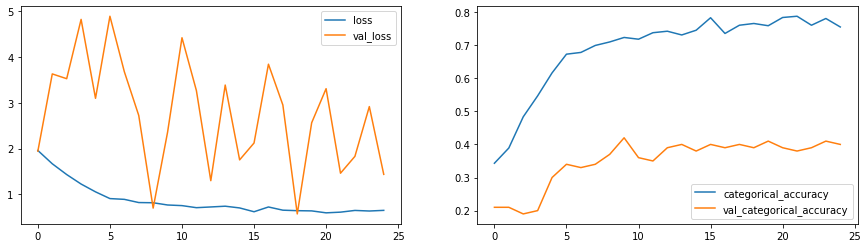

In [42]:
print("Total Params:", conv3d8_model.count_params())
history_model8=conv3d8.train_model(conv3d8_model,augment_data=True)
plot(history_model8)

**Inference**
1. Model is overfitting.
2. Best training accuracy is about 0.78 and validation accuracy is around 0.39.
3. Addition of layers and dropouts didn't improve the performance. Let us reduce network parameters and see.

### Model 9 - CNN+DataAugmentation+Reduced Network Parameters

In [43]:
class ModelConv3D7(ModelClassAugmented):    
    def define_model(self,dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv3d9=ModelConv3D7()
conv3d9.initialize_path(project_folder,9)
conv3d9.initialize_image_properties(image_height=120,image_width=120)
conv3d9.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=30)
conv3d9_model=conv3d9.define_model(dense_neurons=64,dropout=0.25)
conv3d9_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_69 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_99 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_70 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_100 (Bat (None, 8, 60, 60, 16)   

Total Params: 230949
Epoch 1/30
133/133 [==============================] - 152s 1s/step - loss: 2.0381 - categorical_accuracy: 0.2572 - val_loss: 2.5353 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_9_2021-04-1708_22_33.276630/model-00001-2.03576-0.25716-2.53529-0.21000.h5
Epoch 2/30
133/133 [==============================] - 139s 1s/step - loss: 1.6185 - categorical_accuracy: 0.3733 - val_loss: 1.6710 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_9_2021-04-1708_22_33.276630/model-00002-1.61859-0.37330-1.67098-0.23000.h5
Epoch 3/30
133/133 [==============================] - 141s 1s/step - loss: 1.3423 - categorical_accuracy: 0.4894 - val_loss: 0.7475 - val_categorical_accuracy: 0.3100

Epoch 00003: saving model to model_9_2021-04-1708_22_33.276630/model-00003-1.34035-0.48944-0.74748-0.31000.h5
Epoch 4/30
133/133 [==============================] - 138s 1s/step - loss: 1.2726 - categorical_accuracy: 0.5075 - val_loss: 1.4582 - val_categor

133/133 [==============================] - 139s 1s/step - loss: 0.5148 - categorical_accuracy: 0.8183 - val_loss: 0.2346 - val_categorical_accuracy: 0.8800

Epoch 00030: saving model to model_9_2021-04-1708_22_33.276630/model-00030-0.51379-0.81825-0.23460-0.88000.h5


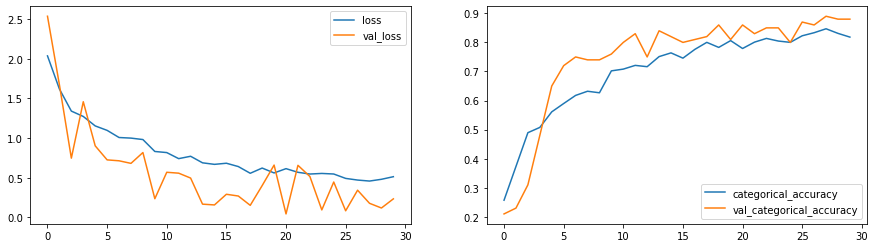

In [45]:
print("Total Params:", conv3d9_model.count_params())
history_model9=conv3d9.train_model(conv3d9_model,augment_data=True)
plot(history_model9)

**Inference**
1. No major overfitting.
2. Best training accuracy is 0.84 and validation accuracy is 0.89.Looks decent.
3. Let us try CNN+RNN architecture and see if it improves the performance.

### Model 10 - CNN+RNN Model

In [46]:
class CNNRNNModel1(ModelClass):    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
      
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
cnnrnn1=CNNRNNModel1()
cnnrnn1.initialize_path(project_folder,10)
cnnrnn1.initialize_image_properties(image_height=120,image_width=120)
cnnrnn1.initialize_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=20)
cnnrnn1_model1=cnnrnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnnrnn1_model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 30, 30, 64)  

Total Params: 1657445
Epoch 1/20
133/133 [==============================] - 192s 1s/step - loss: 1.3416 - categorical_accuracy: 0.4344 - val_loss: 2.1912 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_10_2021-04-1709_32_24.117042/model-00001-1.34279-0.43439-2.19115-0.16000.h5
Epoch 2/20
133/133 [==============================] - 183s 1s/step - loss: 1.0395 - categorical_accuracy: 0.6011 - val_loss: 1.9003 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_10_2021-04-1709_32_24.117042/model-00002-1.04123-0.60106-1.90031-0.16000.h5
Epoch 3/20
133/133 [==============================] - 184s 1s/step - loss: 0.9502 - categorical_accuracy: 0.6290 - val_loss: 1.3121 - val_categorical_accuracy: 0.3400

Epoch 00003: saving model to model_10_2021-04-1709_32_24.117042/model-00003-0.94937-0.62896-1.31212-0.34000.h5
Epoch 4/20
133/133 [==============================] - 183s 1s/step - loss: 0.9067 - categorical_accuracy: 0.6667 - val_loss: 1.9666 - val_cat

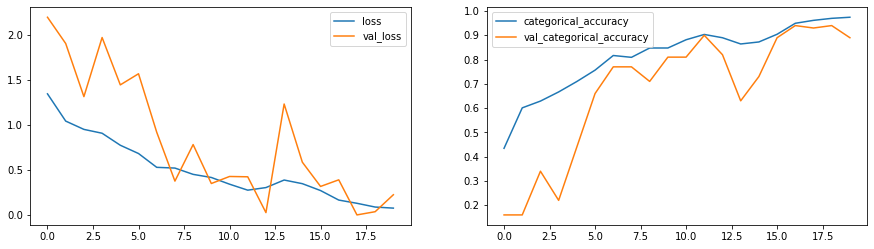

In [48]:
print("Total Params:", cnnrnn1_model1.count_params())
history_model10=cnnrnn1.train_model(cnnrnn1_model1,augment_data=True)
plot(history_model10)

**Inferences**
1. Above plot shows that the model is overfitting.
2. Best training accuracy is 0.97 and best validation accuracy is 0.89.
3. Use Data Augmentation to reduce overfitting problem and improve model performance.

### Model11 - CNN LSTM with GRU

In [49]:
class CNNRNN2(ModelClassAugmented):    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [50]:
cnnrnn2=CNNRNN2()
cnnrnn2.initialize_path(project_folder,11)
cnnrnn2.initialize_image_properties(image_height=120,image_width=120)
cnnrnn2.initialize_hyperparams(frames_to_sample=18,batch_size=5,num_epochs=20)
cnnrnn2_model1=cnnrnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnnrnn2_model1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 30, 30, 64)  

Total Params: 2573541
Epoch 1/20
133/133 [==============================] - 179s 1s/step - loss: 1.3606 - categorical_accuracy: 0.4284 - val_loss: 1.8459 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_11_2021-04-1710_34_19.724271/model-00001-1.36101-0.42836-1.84591-0.24000.h5
Epoch 2/20
133/133 [==============================] - 168s 1s/step - loss: 0.9261 - categorical_accuracy: 0.6569 - val_loss: 2.7446 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_11_2021-04-1710_34_19.724271/model-00002-0.92533-0.65686-2.74464-0.31000.h5
Epoch 3/20
133/133 [==============================] - 172s 1s/step - loss: 0.6719 - categorical_accuracy: 0.7391 - val_loss: 1.1309 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to model_11_2021-04-1710_34_19.724271/model-00003-0.67288-0.73906-1.13095-0.39000.h5
Epoch 4/20
133/133 [==============================] - 168s 1s/step - loss: 0.5183 - categorical_accuracy: 0.8198 - val_loss: 0.7900 - val_cat

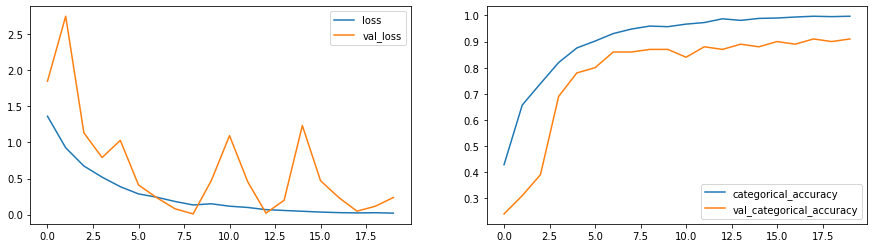

In [51]:
print("Total Params:", cnnrnn2_model1.count_params())
history_model11=cnnrnn2.train_model(cnnrnn2_model1,augment_data=True)
plot(history_model11)

**Inference**
1. Model is overfitting.
2. Best training accuracy is about 0.99 and validation accuracy is 0.91.
3. Let us try transfer learning

### Model 12 - Tranfer Learning

In [54]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
class CNNRNN_TL(ModelClassAugmented):    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [53]:
cnnrnn_tl=CNNRNN_TL()
cnnrnn_tl.initialize_path(project_folder,12)
cnnrnn_tl.initialize_image_properties(image_height=120,image_width=120)
cnnrnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=3,num_epochs=15)
cnnrnn_tl_model1=cnnrnn_tl.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
cnnrnn_tl_model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

Total Params: 3692869
Epoch 1/15
221/221 [==============================] - 213s 965ms/step - loss: 1.0276 - categorical_accuracy: 0.6086 - val_loss: 0.0882 - val_categorical_accuracy: 0.8500

Epoch 00001: saving model to model_12_2021-04-1718_49_08.454639/model-00001-1.02765-0.60860-0.08816-0.85000.h5
Epoch 2/15
221/221 [==============================] - 204s 922ms/step - loss: 0.5194 - categorical_accuracy: 0.8281 - val_loss: 0.0421 - val_categorical_accuracy: 0.8600

Epoch 00002: saving model to model_12_2021-04-1718_49_08.454639/model-00002-0.51944-0.82805-0.04208-0.86000.h5
Epoch 3/15
221/221 [==============================] - 209s 945ms/step - loss: 0.3284 - categorical_accuracy: 0.8967 - val_loss: 0.0025 - val_categorical_accuracy: 0.8900

Epoch 00003: saving model to model_12_2021-04-1718_49_08.454639/model-00003-0.32840-0.89668-0.00249-0.89000.h5
Epoch 4/15
221/221 [==============================] - 203s 917ms/step - loss: 0.2406 - categorical_accuracy: 0.9216 - val_loss: 0.24

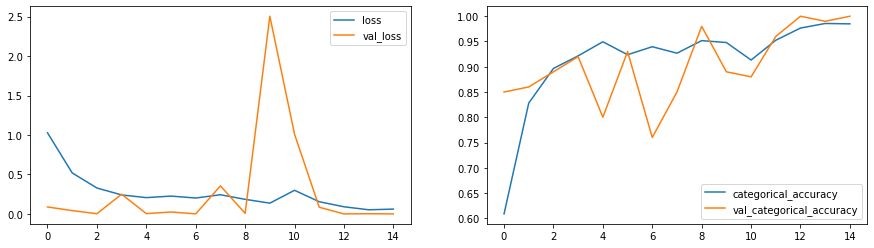

In [54]:
print("Total Params:", cnnrnn_tl_model1.count_params())
history_model12=cnnrnn_tl.train_model(cnnrnn_tl_model1,augment_data=True)
plot(history_model12)

**Inference**
1. Best accuracy is close to 0.986 for training and 0.99 for validation set.
2. Result is not very consistent over many epochs.
3. Let us try to reduce GRU and see.

### Model 13 - Model 12(Transfer learning) with reduced GRU

In [55]:
cnnrnn_tl1=CNNRNN_TL()
cnnrnn_tl1.initialize_path(project_folder,13)
cnnrnn_tl1.initialize_image_properties(image_height=120,image_width=120)
cnnrnn_tl1.initialize_hyperparams(frames_to_sample=15,batch_size=3,num_epochs=15)
cnnrnn_tl1_model2=cnnrnn_tl1.define_model(gru_cells=64,dense_neurons=64,dropout=0.25)
cnnrnn_tl1_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

Total Params: 3446533
Epoch 1/15
221/221 [==============================] - 353s 2s/step - loss: 0.3999 - categorical_accuracy: 0.8635 - val_loss: 0.2193 - val_categorical_accuracy: 0.8300

Epoch 00001: saving model to model_13_2021-04-1719_47_10.234080/model-00001-0.39987-0.86350-0.21933-0.83000.h5
Epoch 2/15
221/221 [==============================] - 332s 2s/step - loss: 0.1963 - categorical_accuracy: 0.9434 - val_loss: 0.0011 - val_categorical_accuracy: 0.9900

Epoch 00002: saving model to model_13_2021-04-1719_47_10.234080/model-00002-0.19633-0.94344-0.00113-0.99000.h5
Epoch 3/15
221/221 [==============================] - 330s 1s/step - loss: 0.2931 - categorical_accuracy: 0.9110 - val_loss: 0.0500 - val_categorical_accuracy: 0.9400

Epoch 00003: saving model to model_13_2021-04-1719_47_10.234080/model-00003-0.29314-0.91101-0.05002-0.94000.h5
Epoch 4/15
221/221 [==============================] - 323s 1s/step - loss: 0.1865 - categorical_accuracy: 0.9487 - val_loss: 0.1650 - val_cat

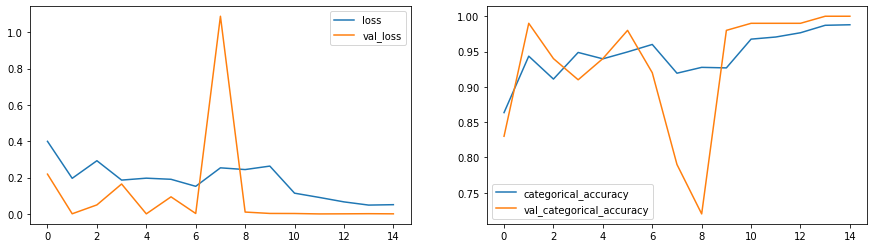

In [56]:
print("Total Params:", cnnrnn_tl1_model2.count_params())
history_model13=cnnrnn_tl1.train_model(cnnrnn_tl1_model2,augment_data=True)
plot(history_model13)

**Inference**
1. Training accuracy of 0.997 and validation accuracy is 0.99. A overfitting scenario.
2. Performance is not very consistent.
3. Fluctutations are seen in accuracy over epochs.

### Model 14 - Model 13 Hypertuned

In [61]:
cnnrnn_tl2=CNNRNN_TL()
cnnrnn_tl2.initialize_path(project_folder,14)
cnnrnn_tl2.initialize_image_properties(image_height=120,image_width=120)
cnnrnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=2,num_epochs=15)
cnnrnn_tl2_model3=cnnrnn_tl2.define_model(gru_cells=64,dense_neurons=64,dropout=0.25)
cnnrnn_tl2_model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)               

Total Params: 3446533
Epoch 1/15
332/332 [==============================] - 199s 601ms/step - loss: 0.3896 - categorical_accuracy: 0.8808 - val_loss: 1.2126 - val_categorical_accuracy: 0.9600

Epoch 00001: saving model to model_14_2021-04-1721_26_27.092555/model-00001-0.38707-0.88084-1.21256-0.96000.h5
Epoch 2/15
332/332 [==============================] - 215s 649ms/step - loss: 0.2995 - categorical_accuracy: 0.9155 - val_loss: 0.0454 - val_categorical_accuracy: 0.8900

Epoch 00002: saving model to model_14_2021-04-1721_26_27.092555/model-00002-0.29991-0.91554-0.04537-0.89000.h5
Epoch 3/15
332/332 [==============================] - 230s 691ms/step - loss: 0.2917 - categorical_accuracy: 0.9178 - val_loss: 0.0304 - val_categorical_accuracy: 0.9400

Epoch 00003: saving model to model_14_2021-04-1721_26_27.092555/model-00003-0.29143-0.91780-0.03038-0.94000.h5
Epoch 4/15
332/332 [==============================] - 259s 780ms/step - loss: 0.2183 - categorical_accuracy: 0.9359 - val_loss: 0.31

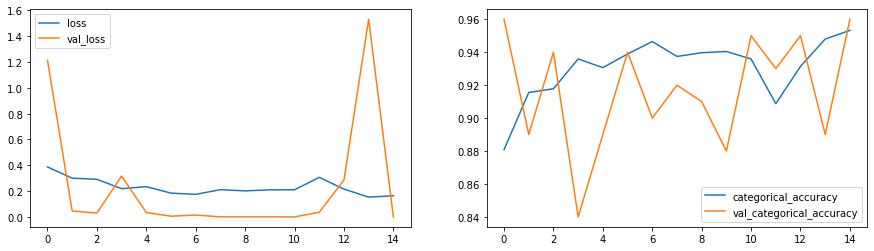

In [62]:
print("Total Params:", cnnrnn_tl2_model3.count_params())
history_model14=cnnrnn_tl2.train_model(cnnrnn_tl2_model3,augment_data=True)
plot(history_model14)

**Inference**
1. Best training accuracy is 0.95 and validation accuracy is 0.96
2. Good performance in transfer learning models.
3. Let us consider this as final model

### Result Summary

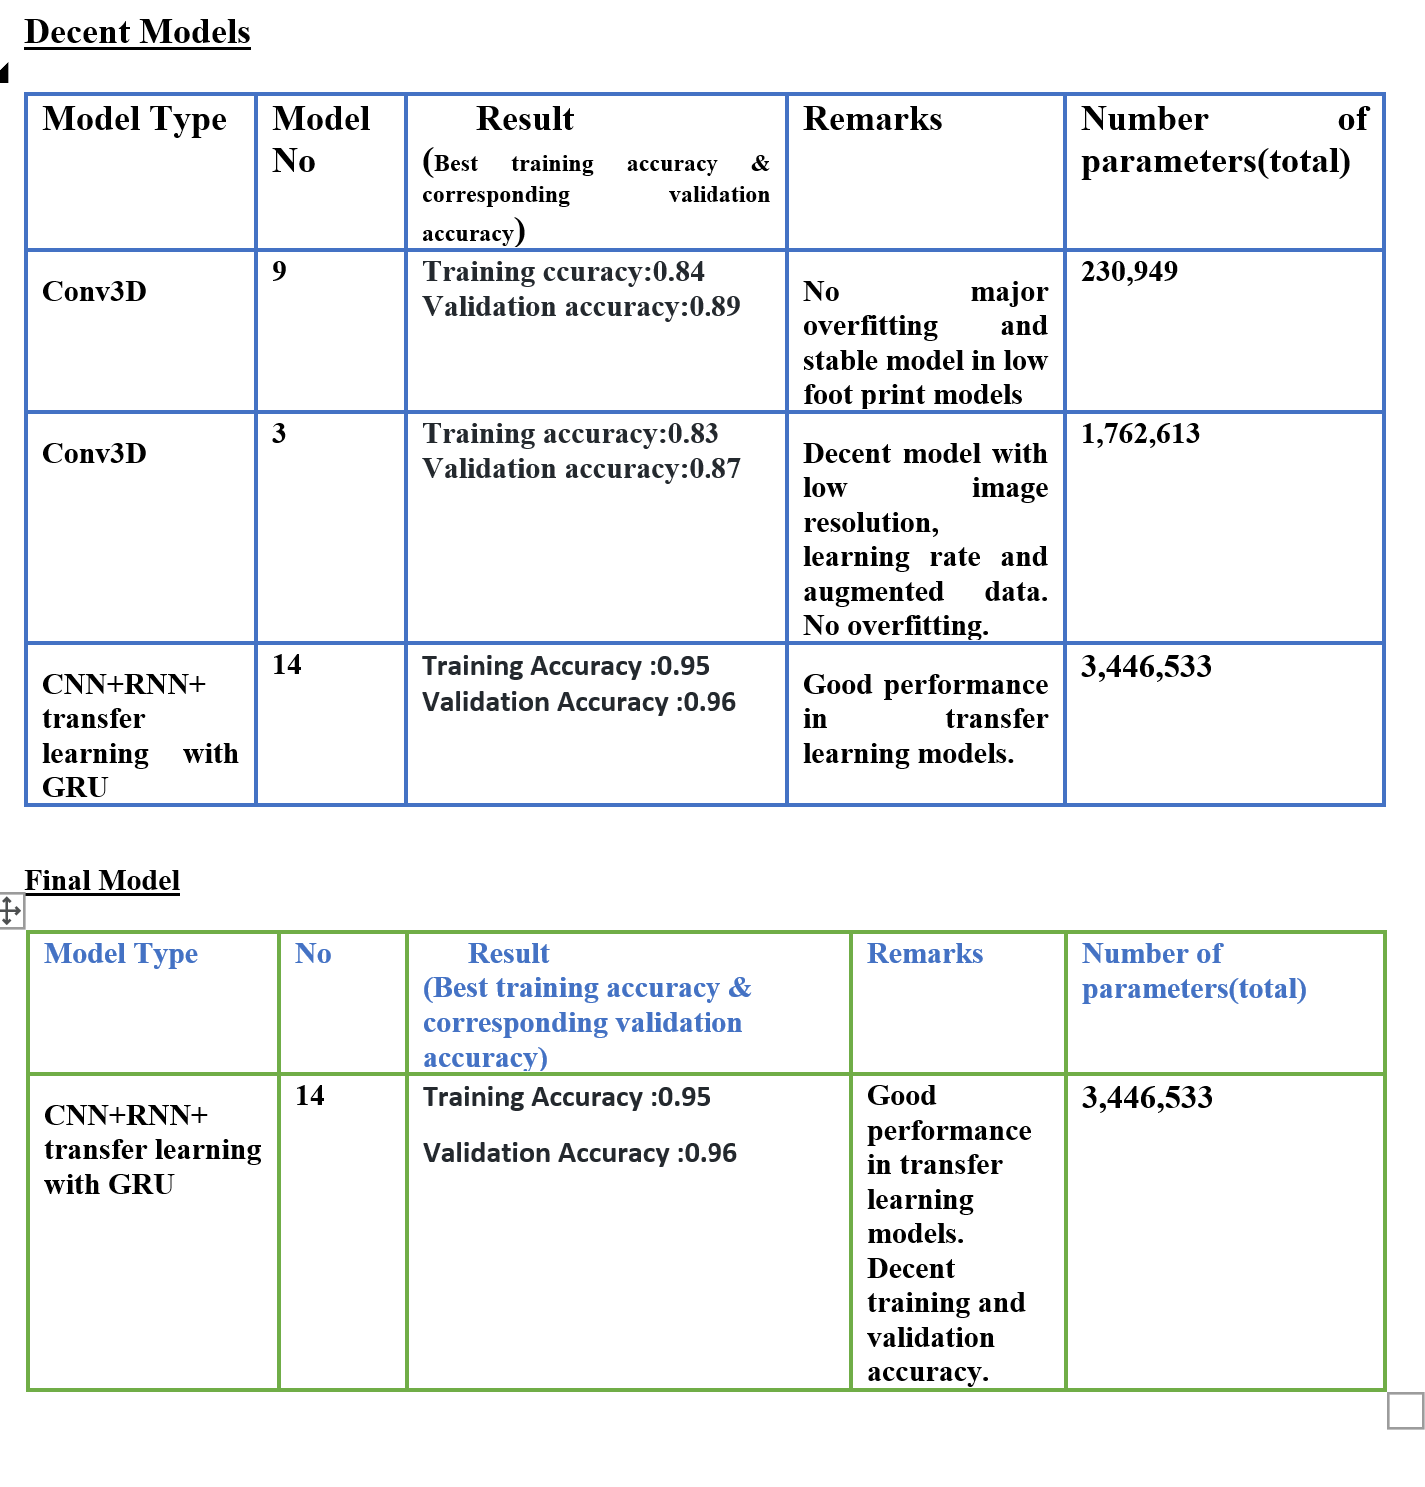

### Testing with final model's .h5 file

In [55]:
import time
from keras.models import load_model
model = load_model('model-00015-0.16367-0.95324-0.00012-0.96000.h5')

In [59]:
test_generator=CNNRNN_TL()
test_generator.initialize_path(project_folder,100)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=2)
g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [60]:
batch_labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [61]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[4 3 1 3 3]
